For the [Accountability hack](https://accountabilityhack.nl/) I am cleaning up data regarding tenders in the Netherlands. These are published on https://www.tenderned.nl/over-tenderned/datasets-aanbestedingen, and this data is in some rough shape. 

You can download the data in cleaned up format from my GitHub. This post is a converted notebook, the original `.ipynb` file can also be found on GitHub. 

## Part I: download the data and combine the frames

First, I extract the relevant links to datasets from the page. The data is contained in Excel files, the links to which can be found on https://www.tenderned.nl/over-tenderned/datasets-aanbestedingen. 

In [1]:
from bs4 import BeautifulSoup
import requests

url = "https://www.tenderned.nl/over-tenderned/datasets-aanbestedingen"

soup  = BeautifulSoup(requests.get(url).content, "html.parser")

links = [link for link in [a.attrs["href"] for a in soup.find_all("a") if "href" in a.attrs] if "Dataset" in link]
links

['https://www.tenderned.nl/cms/sites/default/files/2017-09/Dataset_TenderNed_2010_2011.xlsx',
 'https://www.tenderned.nl/cms/sites/default/files/2017-09/Dataset_TenderNed_2012.xlsx',
 'https://www.tenderned.nl/cms/sites/default/files/2017-09/Dataset_TenderNed_2013.xlsx',
 'https://www.tenderned.nl/cms/sites/default/files/2017-09/Dataset_TenderNed_2014.xlsx',
 'https://www.tenderned.nl/cms/sites/default/files/2017-09/Dataset_TenderNed_2015.xlsx',
 'https://www.tenderned.nl/cms/sites/default/files/2018-01/Dataset_TenderNed_2016.xlsx',
 'https://www.tenderned.nl/cms/sites/default/files/2017-09/Dataset_TenderNed_2017_Q1_Q2.xlsx']

I use pandas to read all the excel files as `pd.DataFrame`, and collect some imports to be used later here. 

In [23]:
import re
import pandas as pd
import seaborn as sns
from functools import reduce

%pylab inline

# this is useful for showing full tables
pd.options.display.max_columns = 100
pd.options.display.max_colwidth = 250
pd.options.display.max_rows = 100

Populating the interactive namespace from numpy and matplotlib


This downloads all the files into a `dict` of frames. The code here takes up to two minutes. Apparently the downloading takes a very long time. The files are not that big, the server is just very slow. 

In [3]:
frames = list()
guides = list()

for link in links:
    
    print(f"Reading {link} ..")
    
    all_sheets = pd.read_excel(link, sheetname = None)
    for nm, sheet in all_sheets.items():
        if nm.startswith("Dataset"):
            print(f"Adding {nm} ..")
            frames.append(sheet.assign(link = link, sheetname = nm))
        elif nm == "Leeswijzer":
            guides.append(sheet.assign(link = link))
        
print(f"Downloaded {len(frames)} separate sheets and {len(guides)} reading guides")

Reading https://www.tenderned.nl/cms/sites/default/files/2017-09/Dataset_TenderNed_2010_2011.xlsx ..
Adding Dataset_TenderNed_2010_2011 ..
Reading https://www.tenderned.nl/cms/sites/default/files/2017-09/Dataset_TenderNed_2012.xlsx ..
Adding Dataset_TenderNed_2012 ..
Reading https://www.tenderned.nl/cms/sites/default/files/2017-09/Dataset_TenderNed_2013.xlsx ..
Adding Dataset_TenderNed_2013 ..
Reading https://www.tenderned.nl/cms/sites/default/files/2017-09/Dataset_TenderNed_2014.xlsx ..
Adding Dataset_TenderNed_2014 ..
Reading https://www.tenderned.nl/cms/sites/default/files/2017-09/Dataset_TenderNed_2015.xlsx ..
Adding Dataset_TenderNed_2015 ..
Reading https://www.tenderned.nl/cms/sites/default/files/2018-01/Dataset_TenderNed_2016.xlsx ..
Adding Dataset_TenderNed_2016_Q1_Q2 ..
Adding Dataset_TenderNed_2016_Q3_Q4 ..
Reading https://www.tenderned.nl/cms/sites/default/files/2017-09/Dataset_TenderNed_2017_Q1_Q2.xlsx ..
Adding Dataset_TenderNed_2017_Q1_Q2 ..
Downloaded 8 separate sheets a

The colums are not the same among all of the frames, so let's create a heatmap to see what's missing where. 

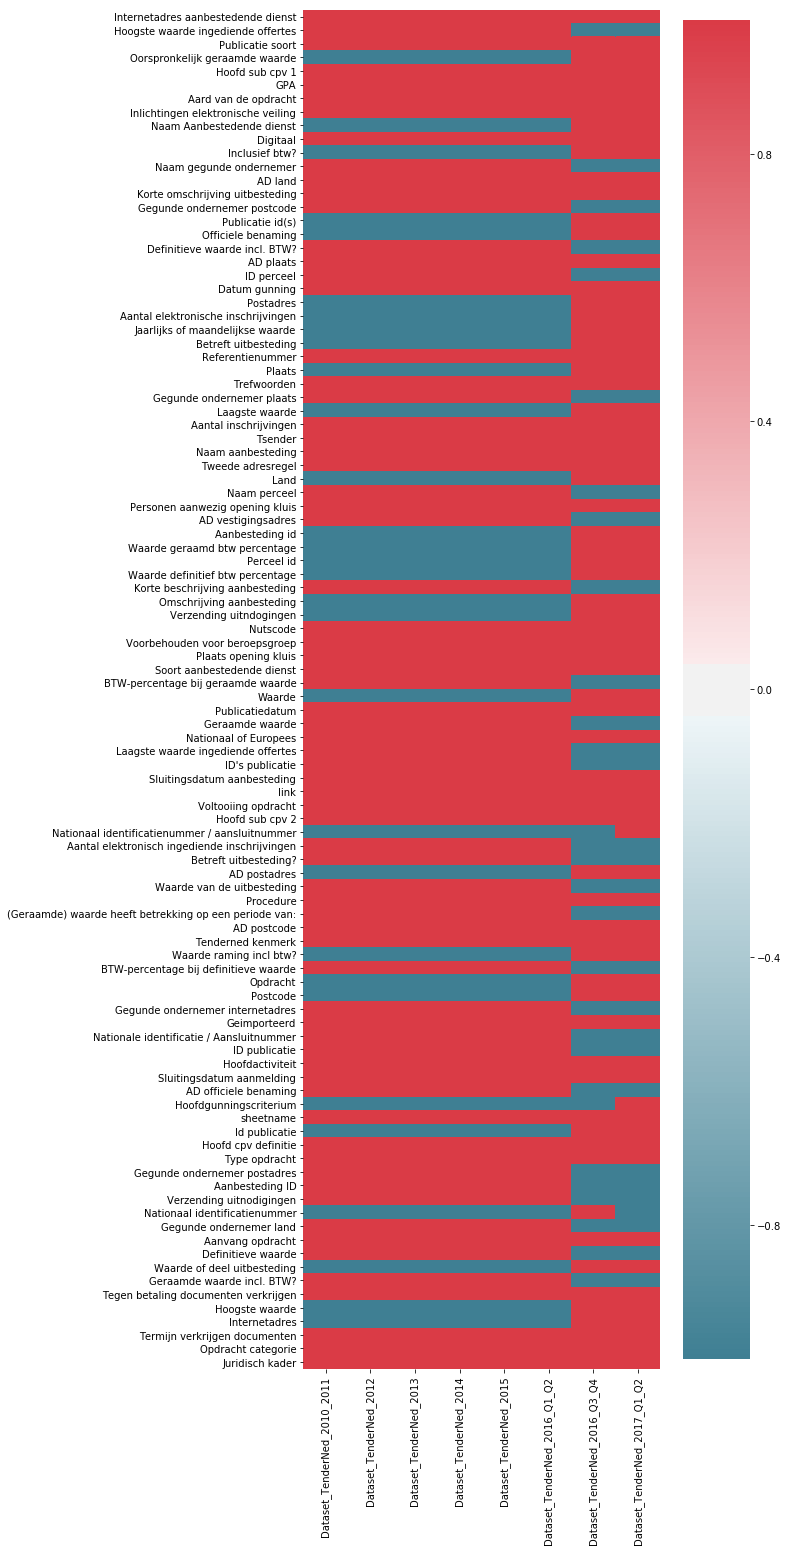

In [39]:
all_columns = set(reduce(lambda x, y: x + y, [list(df.columns) for df in frames]))

missing = pd.DataFrame(index=all_columns)

for frame in frames: missing.loc[frame.columns, frame.loc[0, "sheetname"]] = 1 

plt.figure(figsize = (8, 25))
sns.heatmap(missing.fillna(-1), cmap = sns.diverging_palette(220, 10, as_cmap=True));

Lots of columns, lots of vague names. Also, the last two are in a different format, or in a kind of transitionary format. Lets look at the reading guides. 

In [13]:
guide = guides[0].drop(list(range(10)))
guide.columns = "param", "description", "link"
guide.head()

,param,description,link
10,ID publicatie,"Uniek kenmerk (ID), dat TenderNed toekent aan ...",https://www.tenderned.nl/cms/sites/default/fil...
11,Tenderned kenmerk,"Uniek kenmerk (ID), dat TenderNed toekent aan ...",https://www.tenderned.nl/cms/sites/default/fil...
12,Publicatiedatum,De datum waarop de aankondiging is gepubliceerd,https://www.tenderned.nl/cms/sites/default/fil...
13,AD officiele benaming,De naam van de aanbestedende dienst,https://www.tenderned.nl/cms/sites/default/fil...
14,Nationale identificatie / Aansluitnummer,Het unieke aansluitnummer van een aanbestedend...,https://www.tenderned.nl/cms/sites/default/fil...


Allright. I don't like the ugly column names, with spaces, and some even have a question mark at the end. WTF? Unfortunately, there is no functionality like `janitor::clean_names` in `R` available in python (anyone?), so I'll hack my own for now. 

In [16]:
import string

def sanitize(name):
    
    t = "".join([c if c in string.ascii_lowercase + string.digits else "_" for c in name.lower()])
    return re.sub(r"_+", "_", t).lstrip("_").rstrip("_")
     
sanitize(frames[0].columns[-3])

'korte_omschrijving_uitbesteding'

Now I'll merge the frames, except the one with the different column names, into one, while also sanitizing each frame and adding a reference to the source. 

In [24]:
tenders = pd.concat([f.rename(columns = sanitize) for f in frames if "Hoogste waarde ingediende offertes" in f.columns])
tenders.head()

,id_publicatie,tenderned_kenmerk,publicatiedatum,ad_officiele_benaming,nationale_identificatie_aansluitnummer,naam_aanbesteding,geimporteerd,tsender,aanbesteding_id,sluitingsdatum_aanmelding,sluitingsdatum_aanbesteding,aanvang_opdracht,voltooiing_opdracht,termijn_verkrijgen_documenten,verzending_uitnodigingen,tegen_betaling_documenten_verkrijgen,personen_aanwezig_opening_kluis,plaats_opening_kluis,nationaal_of_europees,korte_beschrijving_aanbesteding,publicatie_soort,juridisch_kader,type_opdracht,procedure,trefwoorden,referentienummer,digitaal,voorbehouden_voor_beroepsgroep,hoofd_cpv_definitie,hoofd_sub_cpv_1,hoofd_sub_cpv_2,opdracht_categorie,nutscode,aard_van_de_opdracht,gpa,inlichtingen_elektronische_veiling,ad_vestigingsadres,tweede_adresregel,ad_plaats,ad_postcode,ad_land,internetadres_aanbestedende_dienst,soort_aanbestedende_dienst,hoofdactiviteit,id_s_publicatie,id_perceel,naam_perceel,datum_gunning,aantal_inschrijvingen,aantal_elektronisch_ingediende_inschrijvingen,naam_gegunde_ondernemer,gegunde_ondernemer_postadres,gegunde_ondernemer_plaats,gegunde_ondernemer_postcode,gegunde_ondernemer_land,gegunde_ondernemer_internetadres,geraamde_waarde,btw_percentage_bij_geraamde_waarde,geraamde_waarde_incl_btw,laagste_waarde_ingediende_offertes,hoogste_waarde_ingediende_offertes,geraamde_waarde_heeft_betrekking_op_een_periode_van,definitieve_waarde,btw_percentage_bij_definitieve_waarde,definitieve_waarde_incl_btw,betreft_uitbesteding,waarde_van_de_uitbesteding,korte_omschrijving_uitbesteding,link,sheetname
0,550,551,03-12-2010,Rijkswaterstaat Noord-Brabant,51,"Gladheidsbestrijding RWS Noord-Brabant, gemeente Breda en Provincie Noord-Brabant",Nee,NaN,551,NaN,24-02-2011,01-10-2011,01-05-2014,24-02-2011,NaN,Nee,Nee,'s-Hertogenbosch,Europees,"ZaakId 31046957, bestek voor het coördineren en het uitvoeren van de gladheidbestrijding op alle autosnelwegen, alle gebiedsontsluitingswegen, een groot deel van de toegangswegen, fietspaden en opstelterreinen c.a. binnen het beheersgebied van Ri...",Aankondiging van een opdracht,"BAO - Besluit Aanbestedingsregels voor Overheidsopdrachten, dd 16 juli 2005",Diensten,Openbaar,NaN,31046957,Nee,NaN,90620000-9 Sneeuwruimingsdiensten,NaN,NaN,Straatreiniging en afvalverzameling; afvalwaterverzameling en -verwerking en aanverwante diensten,NL41,Overheidsopdracht,Ja,Nee,Zuidwal 58,NaN,'s-Hertogenbosch,5211 JK,Nederland,http://www.rijkswaterstaat.nl,"Ministerie of andere nationale of federale instantie, met regionale of plaatselijke onderverdeling ervan",Algemene overheidsdiensten,"1301, 550",551.0,"Rijkswaterstaat Noord-Brabant, wegendistrict Breda, Provincie Noord-Brabant en gemeente Breda.",30-03-2011,2.0,0.0,Combinatie Roos/Vervat,Postbus 61,Bladel,5530 AB,NL,NaN,NaN,NaN,Nee,NaN,NaN,3 Jaren,EUR 3375000,NaN,Nee,Ja,Onbekend,NaN,https://www.tenderned.nl/cms/sites/default/files/2017-09/Dataset_TenderNed_2010_2011.xlsx,Dataset_TenderNed_2010_2011
1,550,551,03-12-2010,Rijkswaterstaat Noord-Brabant,51,"Gladheidsbestrijding RWS Noord-Brabant, gemeente Breda en Provincie Noord-Brabant",Nee,NaN,551,NaN,24-02-2011,01-10-2011,01-05-2014,24-02-2011,NaN,Nee,Nee,'s-Hertogenbosch,Europees,"ZaakId 31046957, bestek voor het coördineren en het uitvoeren van de gladheidbestrijding op alle autosnelwegen, alle gebiedsontsluitingswegen, een groot deel van de toegangswegen, fietspaden en opstelterreinen c.a. binnen het beheersgebied van Ri...",Aankondiging van een opdracht,"BAO - Besluit Aanbestedingsregels voor Overheidsopdrachten, dd 16 juli 2005",Diensten,Openbaar,NaN,31046957,Nee,NaN,90620000-9 Sneeuwruimingsdiensten,NaN,NaN,Straatreiniging en afvalverzameling; afvalwaterverzameling en -verwerking en aanverwante diensten,NL41,Overheidsopdracht,Ja,Nee,Zuidwal 58,NaN,'s-Hertogenbosch,5211 JK,Nederland,http://www.rijkswaterstaat.nl,"Ministerie of andere nationale of federale instantie, met regionale of plaatselijke onderverdeling ervan",Algemene overheidsdiensten,"1301, 550",550.0,"Rijkswaterstaat Noord-Brabant, wegendistr

In [18]:
tenders.shape

(58289, 70)

In [25]:
guide["short"] = guide.param.map(sanitize)
guide.head()

,param,description,link,short
10,ID publicatie,"Uniek kenmerk (ID), dat TenderNed toekent aan een aankondiging",https://www.tenderned.nl/cms/sites/default/files/2017-09/Dataset_TenderNed_2010_2011.xlsx,id_publicatie
11,Tenderned kenmerk,"Uniek kenmerk (ID), dat TenderNed toekent aan een aanbesteding. Een openbare aanbesteding heeft in de regel meerdere aankondigingen",https://www.tenderned.nl/cms/sites/default/files/2017-09/Dataset_TenderNed_2010_2011.xlsx,tenderned_kenmerk
12,Publicatiedatum,De datum waarop de aankondiging is gepubliceerd,https://www.tenderned.nl/cms/sites/default/files/2017-09/Dataset_TenderNed_2010_2011.xlsx,publicatiedatum
13,AD officiele benaming,De naam van de aanbestedende dienst,https://www.tenderned.nl/cms/sites/default/files/2017-09/Dataset_TenderNed_2010_2011.xlsx,ad_officiele_benaming
14,Nationale identificatie / Aansluitnummer,Het unieke aansluitnummer van een aanbestedende dienst op Tenderned (afgegeven ten tijde van de registratie van de aanbestedende dienst),https://www.tenderned.nl/cms/sites/default/files/2017-09/Dataset_TenderNed_2010_2011.xlsx,nationale_identificatie_aansluitnummer


The first thing I always do in a dataset is checking the id's, and if they're actually unique. Terrible datasets have duplicated id's, many of them, and have all kinds of redundant data. This one, as mentioned earlier, is terrible. There are multiple redundancies, the result of joining multiple tables together. I could go into the law and figure out which columns are which, but I'm actually interested if I can figure out this dependency structure automatically. _The following is work in progress_. 

In [127]:
def count_dupes(col):
    return pd.Series({
        "duplications": col.duplicated().sum(), 
        "unique_values": len(col.unique()),
        "na": col.isnull().sum(), 
        "na + duplications": (col.duplicated() | col.isnull()).sum()
    })

tenders.apply(count_dupes, axis = 0).T.sort_values("duplications")

,duplications,na,na + duplications,unique_values
id_publicatie,14994,0,14994,43295
tenderned_kenmerk,33137,0,33137,25152
aanbesteding_id,33137,0,33137,25152
korte_beschrijving_aanbesteding,35803,51,35804,22486
naam_aanbesteding,36222,0,36222,22067
referentienummer,41271,13614,41272,17018
trefwoorden,48636,10465,48637,9653
naam_gegunde_ondernemer,50474,29203,50475,7815
id_s_publicatie,50999,29203,51000,7290
gegunde_ondernemer_postcode,51968,29432,51969,6321


In [94]:
def comb_numbers(df, col_from, col_to):
    
    q = ~df[[col_from, col_to]].duplicated()
    view = df[q].fillna('none')

    return view[col_to].groupby(view[col_from]).size().value_counts(dropna = False)
    
def implies_unique(df, col_from, col_to):
    
    comb_nums = comb_numbers(df, col_from, col_to)
    try:
        return (comb_nums.loc[1] == comb_nums.sum())
    except KeyError:
        return False
    
implies_unique(tenders, "id_publicatie", "tenderned_kenmerk")

True

In [88]:
implies_unique(tenders, "tenderned_kenmerk", "id_publicatie")

False

In [96]:
import networkx as nx

uniqueness_graph = nx.DiGraph()

uniqueness_graph.add_nodes_from(tenders.columns)

In [97]:
from itertools import combinations

for col_from, col_to in combinations(tenders.columns, 2):
    print(f"Testing {col_from} to {col_to} ...")
    if implies_unique(tenders, col_from, col_to):
        print("** <-")
        uniqueness_graph.add_edge(col_from, col_to)

Testing id_publicatie to tenderned_kenmerk ...
** <-
Testing id_publicatie to publicatiedatum ...
** <-
Testing id_publicatie to ad_officiele_benaming ...
** <-
Testing id_publicatie to nationale_identificatie_aansluitnummer ...
** <-
Testing id_publicatie to naam_aanbesteding ...
** <-
Testing id_publicatie to geimporteerd ...
** <-
Testing id_publicatie to tsender ...
** <-
Testing id_publicatie to aanbesteding_id ...
** <-
Testing id_publicatie to sluitingsdatum_aanmelding ...
** <-
Testing id_publicatie to sluitingsdatum_aanbesteding ...
** <-
Testing id_publicatie to aanvang_opdracht ...
** <-
Testing id_publicatie to voltooiing_opdracht ...
** <-
Testing id_publicatie to termijn_verkrijgen_documenten ...
** <-
Testing id_publicatie to verzending_uitnodigingen ...
** <-
Testing id_publicatie to tegen_betaling_documenten_verkrijgen ...
** <-
Testing id_publicatie to personen_aanwezig_opening_kluis ...
** <-
Testing id_publicatie to plaats_opening_kluis ...
** <-
Testing id_publicat

Testing publicatiedatum to termijn_verkrijgen_documenten ...
Testing publicatiedatum to verzending_uitnodigingen ...
Testing publicatiedatum to tegen_betaling_documenten_verkrijgen ...
Testing publicatiedatum to personen_aanwezig_opening_kluis ...
Testing publicatiedatum to plaats_opening_kluis ...
Testing publicatiedatum to nationaal_of_europees ...
Testing publicatiedatum to korte_beschrijving_aanbesteding ...
Testing publicatiedatum to publicatie_soort ...
Testing publicatiedatum to juridisch_kader ...
Testing publicatiedatum to type_opdracht ...
Testing publicatiedatum to procedure ...
Testing publicatiedatum to trefwoorden ...
Testing publicatiedatum to referentienummer ...
Testing publicatiedatum to digitaal ...
Testing publicatiedatum to voorbehouden_voor_beroepsgroep ...
Testing publicatiedatum to hoofd_cpv_definitie ...
Testing publicatiedatum to hoofd_sub_cpv_1 ...
Testing publicatiedatum to hoofd_sub_cpv_2 ...
Testing publicatiedatum to opdracht_categorie ...
Testing publica

Testing nationale_identificatie_aansluitnummer to trefwoorden ...
Testing nationale_identificatie_aansluitnummer to referentienummer ...
Testing nationale_identificatie_aansluitnummer to digitaal ...
Testing nationale_identificatie_aansluitnummer to voorbehouden_voor_beroepsgroep ...
Testing nationale_identificatie_aansluitnummer to hoofd_cpv_definitie ...
Testing nationale_identificatie_aansluitnummer to hoofd_sub_cpv_1 ...
Testing nationale_identificatie_aansluitnummer to hoofd_sub_cpv_2 ...
Testing nationale_identificatie_aansluitnummer to opdracht_categorie ...
Testing nationale_identificatie_aansluitnummer to nutscode ...
Testing nationale_identificatie_aansluitnummer to aard_van_de_opdracht ...
Testing nationale_identificatie_aansluitnummer to gpa ...
Testing nationale_identificatie_aansluitnummer to inlichtingen_elektronische_veiling ...
Testing nationale_identificatie_aansluitnummer to ad_vestigingsadres ...
Testing nationale_identificatie_aansluitnummer to tweede_adresregel ..

Testing geimporteerd to aard_van_de_opdracht ...
Testing geimporteerd to gpa ...
Testing geimporteerd to inlichtingen_elektronische_veiling ...
Testing geimporteerd to ad_vestigingsadres ...
Testing geimporteerd to tweede_adresregel ...
Testing geimporteerd to ad_plaats ...
Testing geimporteerd to ad_postcode ...
Testing geimporteerd to ad_land ...
Testing geimporteerd to internetadres_aanbestedende_dienst ...
Testing geimporteerd to soort_aanbestedende_dienst ...
Testing geimporteerd to hoofdactiviteit ...
Testing geimporteerd to id_s_publicatie ...
Testing geimporteerd to id_perceel ...
Testing geimporteerd to naam_perceel ...
Testing geimporteerd to datum_gunning ...
Testing geimporteerd to aantal_inschrijvingen ...
Testing geimporteerd to aantal_elektronisch_ingediende_inschrijvingen ...
Testing geimporteerd to naam_gegunde_ondernemer ...
Testing geimporteerd to gegunde_ondernemer_postadres ...
Testing geimporteerd to gegunde_ondernemer_plaats ...
Testing geimporteerd to gegunde_on

Testing sluitingsdatum_aanmelding to verzending_uitnodigingen ...
Testing sluitingsdatum_aanmelding to tegen_betaling_documenten_verkrijgen ...
Testing sluitingsdatum_aanmelding to personen_aanwezig_opening_kluis ...
Testing sluitingsdatum_aanmelding to plaats_opening_kluis ...
Testing sluitingsdatum_aanmelding to nationaal_of_europees ...
Testing sluitingsdatum_aanmelding to korte_beschrijving_aanbesteding ...
Testing sluitingsdatum_aanmelding to publicatie_soort ...
Testing sluitingsdatum_aanmelding to juridisch_kader ...
Testing sluitingsdatum_aanmelding to type_opdracht ...
Testing sluitingsdatum_aanmelding to procedure ...
Testing sluitingsdatum_aanmelding to trefwoorden ...
Testing sluitingsdatum_aanmelding to referentienummer ...
Testing sluitingsdatum_aanmelding to digitaal ...
Testing sluitingsdatum_aanmelding to voorbehouden_voor_beroepsgroep ...
Testing sluitingsdatum_aanmelding to hoofd_cpv_definitie ...
Testing sluitingsdatum_aanmelding to hoofd_sub_cpv_1 ...
Testing sluit

Testing aanvang_opdracht to hoofd_sub_cpv_1 ...
Testing aanvang_opdracht to hoofd_sub_cpv_2 ...
Testing aanvang_opdracht to opdracht_categorie ...
Testing aanvang_opdracht to nutscode ...
Testing aanvang_opdracht to aard_van_de_opdracht ...
Testing aanvang_opdracht to gpa ...
Testing aanvang_opdracht to inlichtingen_elektronische_veiling ...
Testing aanvang_opdracht to ad_vestigingsadres ...
Testing aanvang_opdracht to tweede_adresregel ...
Testing aanvang_opdracht to ad_plaats ...
Testing aanvang_opdracht to ad_postcode ...
Testing aanvang_opdracht to ad_land ...
Testing aanvang_opdracht to internetadres_aanbestedende_dienst ...
Testing aanvang_opdracht to soort_aanbestedende_dienst ...
Testing aanvang_opdracht to hoofdactiviteit ...
Testing aanvang_opdracht to id_s_publicatie ...
Testing aanvang_opdracht to id_perceel ...
Testing aanvang_opdracht to naam_perceel ...
Testing aanvang_opdracht to datum_gunning ...
Testing aanvang_opdracht to aantal_inschrijvingen ...
Testing aanvang_opd

Testing termijn_verkrijgen_documenten to geraamde_waarde_incl_btw ...
Testing termijn_verkrijgen_documenten to laagste_waarde_ingediende_offertes ...
Testing termijn_verkrijgen_documenten to hoogste_waarde_ingediende_offertes ...
Testing termijn_verkrijgen_documenten to geraamde_waarde_heeft_betrekking_op_een_periode_van ...
Testing termijn_verkrijgen_documenten to definitieve_waarde ...
Testing termijn_verkrijgen_documenten to btw_percentage_bij_definitieve_waarde ...
Testing termijn_verkrijgen_documenten to definitieve_waarde_incl_btw ...
Testing termijn_verkrijgen_documenten to betreft_uitbesteding ...
Testing termijn_verkrijgen_documenten to waarde_van_de_uitbesteding ...
Testing termijn_verkrijgen_documenten to korte_omschrijving_uitbesteding ...
Testing termijn_verkrijgen_documenten to link ...
Testing termijn_verkrijgen_documenten to sheetname ...
Testing verzending_uitnodigingen to tegen_betaling_documenten_verkrijgen ...
Testing verzending_uitnodigingen to personen_aanwezig_op

Testing personen_aanwezig_opening_kluis to plaats_opening_kluis ...
Testing personen_aanwezig_opening_kluis to nationaal_of_europees ...
Testing personen_aanwezig_opening_kluis to korte_beschrijving_aanbesteding ...
Testing personen_aanwezig_opening_kluis to publicatie_soort ...
Testing personen_aanwezig_opening_kluis to juridisch_kader ...
Testing personen_aanwezig_opening_kluis to type_opdracht ...
Testing personen_aanwezig_opening_kluis to procedure ...
Testing personen_aanwezig_opening_kluis to trefwoorden ...
Testing personen_aanwezig_opening_kluis to referentienummer ...
Testing personen_aanwezig_opening_kluis to digitaal ...
Testing personen_aanwezig_opening_kluis to voorbehouden_voor_beroepsgroep ...
Testing personen_aanwezig_opening_kluis to hoofd_cpv_definitie ...
Testing personen_aanwezig_opening_kluis to hoofd_sub_cpv_1 ...
Testing personen_aanwezig_opening_kluis to hoofd_sub_cpv_2 ...
Testing personen_aanwezig_opening_kluis to opdracht_categorie ...
Testing personen_aanwez

Testing nationaal_of_europees to gegunde_ondernemer_plaats ...
Testing nationaal_of_europees to gegunde_ondernemer_postcode ...
Testing nationaal_of_europees to gegunde_ondernemer_land ...
Testing nationaal_of_europees to gegunde_ondernemer_internetadres ...
Testing nationaal_of_europees to geraamde_waarde ...
Testing nationaal_of_europees to btw_percentage_bij_geraamde_waarde ...
Testing nationaal_of_europees to geraamde_waarde_incl_btw ...
Testing nationaal_of_europees to laagste_waarde_ingediende_offertes ...
Testing nationaal_of_europees to hoogste_waarde_ingediende_offertes ...
Testing nationaal_of_europees to geraamde_waarde_heeft_betrekking_op_een_periode_van ...
Testing nationaal_of_europees to definitieve_waarde ...
Testing nationaal_of_europees to btw_percentage_bij_definitieve_waarde ...
Testing nationaal_of_europees to definitieve_waarde_incl_btw ...
Testing nationaal_of_europees to betreft_uitbesteding ...
Testing nationaal_of_europees to waarde_van_de_uitbesteding ...
Tes

Testing juridisch_kader to id_perceel ...
Testing juridisch_kader to naam_perceel ...
Testing juridisch_kader to datum_gunning ...
Testing juridisch_kader to aantal_inschrijvingen ...
Testing juridisch_kader to aantal_elektronisch_ingediende_inschrijvingen ...
Testing juridisch_kader to naam_gegunde_ondernemer ...
Testing juridisch_kader to gegunde_ondernemer_postadres ...
Testing juridisch_kader to gegunde_ondernemer_plaats ...
Testing juridisch_kader to gegunde_ondernemer_postcode ...
Testing juridisch_kader to gegunde_ondernemer_land ...
Testing juridisch_kader to gegunde_ondernemer_internetadres ...
Testing juridisch_kader to geraamde_waarde ...
Testing juridisch_kader to btw_percentage_bij_geraamde_waarde ...
Testing juridisch_kader to geraamde_waarde_incl_btw ...
Testing juridisch_kader to laagste_waarde_ingediende_offertes ...
Testing juridisch_kader to hoogste_waarde_ingediende_offertes ...
Testing juridisch_kader to geraamde_waarde_heeft_betrekking_op_een_periode_van ...
Testi

Testing referentienummer to digitaal ...
Testing referentienummer to voorbehouden_voor_beroepsgroep ...
Testing referentienummer to hoofd_cpv_definitie ...
Testing referentienummer to hoofd_sub_cpv_1 ...
Testing referentienummer to hoofd_sub_cpv_2 ...
Testing referentienummer to opdracht_categorie ...
Testing referentienummer to nutscode ...
Testing referentienummer to aard_van_de_opdracht ...
Testing referentienummer to gpa ...
Testing referentienummer to inlichtingen_elektronische_veiling ...
Testing referentienummer to ad_vestigingsadres ...
Testing referentienummer to tweede_adresregel ...
Testing referentienummer to ad_plaats ...
Testing referentienummer to ad_postcode ...
Testing referentienummer to ad_land ...
Testing referentienummer to internetadres_aanbestedende_dienst ...
Testing referentienummer to soort_aanbestedende_dienst ...
Testing referentienummer to hoofdactiviteit ...
Testing referentienummer to id_s_publicatie ...
Testing referentienummer to id_perceel ...
Testing 

Testing hoofd_cpv_definitie to aantal_inschrijvingen ...
Testing hoofd_cpv_definitie to aantal_elektronisch_ingediende_inschrijvingen ...
Testing hoofd_cpv_definitie to naam_gegunde_ondernemer ...
Testing hoofd_cpv_definitie to gegunde_ondernemer_postadres ...
Testing hoofd_cpv_definitie to gegunde_ondernemer_plaats ...
Testing hoofd_cpv_definitie to gegunde_ondernemer_postcode ...
Testing hoofd_cpv_definitie to gegunde_ondernemer_land ...
Testing hoofd_cpv_definitie to gegunde_ondernemer_internetadres ...
Testing hoofd_cpv_definitie to geraamde_waarde ...
Testing hoofd_cpv_definitie to btw_percentage_bij_geraamde_waarde ...
Testing hoofd_cpv_definitie to geraamde_waarde_incl_btw ...
Testing hoofd_cpv_definitie to laagste_waarde_ingediende_offertes ...
Testing hoofd_cpv_definitie to hoogste_waarde_ingediende_offertes ...
Testing hoofd_cpv_definitie to geraamde_waarde_heeft_betrekking_op_een_periode_van ...
Testing hoofd_cpv_definitie to definitieve_waarde ...
Testing hoofd_cpv_definiti

Testing nutscode to naam_perceel ...
Testing nutscode to datum_gunning ...
Testing nutscode to aantal_inschrijvingen ...
Testing nutscode to aantal_elektronisch_ingediende_inschrijvingen ...
Testing nutscode to naam_gegunde_ondernemer ...
Testing nutscode to gegunde_ondernemer_postadres ...
Testing nutscode to gegunde_ondernemer_plaats ...
Testing nutscode to gegunde_ondernemer_postcode ...
Testing nutscode to gegunde_ondernemer_land ...
Testing nutscode to gegunde_ondernemer_internetadres ...
Testing nutscode to geraamde_waarde ...
Testing nutscode to btw_percentage_bij_geraamde_waarde ...
Testing nutscode to geraamde_waarde_incl_btw ...
Testing nutscode to laagste_waarde_ingediende_offertes ...
Testing nutscode to hoogste_waarde_ingediende_offertes ...
Testing nutscode to geraamde_waarde_heeft_betrekking_op_een_periode_van ...
Testing nutscode to definitieve_waarde ...
Testing nutscode to btw_percentage_bij_definitieve_waarde ...
Testing nutscode to definitieve_waarde_incl_btw ...
Te

Testing ad_vestigingsadres to gegunde_ondernemer_postcode ...
Testing ad_vestigingsadres to gegunde_ondernemer_land ...
Testing ad_vestigingsadres to gegunde_ondernemer_internetadres ...
Testing ad_vestigingsadres to geraamde_waarde ...
Testing ad_vestigingsadres to btw_percentage_bij_geraamde_waarde ...
Testing ad_vestigingsadres to geraamde_waarde_incl_btw ...
Testing ad_vestigingsadres to laagste_waarde_ingediende_offertes ...
Testing ad_vestigingsadres to hoogste_waarde_ingediende_offertes ...
Testing ad_vestigingsadres to geraamde_waarde_heeft_betrekking_op_een_periode_van ...
Testing ad_vestigingsadres to definitieve_waarde ...
Testing ad_vestigingsadres to btw_percentage_bij_definitieve_waarde ...
Testing ad_vestigingsadres to definitieve_waarde_incl_btw ...
Testing ad_vestigingsadres to betreft_uitbesteding ...
Testing ad_vestigingsadres to waarde_van_de_uitbesteding ...
Testing ad_vestigingsadres to korte_omschrijving_uitbesteding ...
Testing ad_vestigingsadres to link ...
Tes

Testing internetadres_aanbestedende_dienst to gegunde_ondernemer_land ...
Testing internetadres_aanbestedende_dienst to gegunde_ondernemer_internetadres ...
Testing internetadres_aanbestedende_dienst to geraamde_waarde ...
Testing internetadres_aanbestedende_dienst to btw_percentage_bij_geraamde_waarde ...
Testing internetadres_aanbestedende_dienst to geraamde_waarde_incl_btw ...
Testing internetadres_aanbestedende_dienst to laagste_waarde_ingediende_offertes ...
Testing internetadres_aanbestedende_dienst to hoogste_waarde_ingediende_offertes ...
Testing internetadres_aanbestedende_dienst to geraamde_waarde_heeft_betrekking_op_een_periode_van ...
Testing internetadres_aanbestedende_dienst to definitieve_waarde ...
Testing internetadres_aanbestedende_dienst to btw_percentage_bij_definitieve_waarde ...
Testing internetadres_aanbestedende_dienst to definitieve_waarde_incl_btw ...
Testing internetadres_aanbestedende_dienst to betreft_uitbesteding ...
Testing internetadres_aanbestedende_die

Testing naam_perceel to waarde_van_de_uitbesteding ...
Testing naam_perceel to korte_omschrijving_uitbesteding ...
Testing naam_perceel to link ...
Testing naam_perceel to sheetname ...
Testing datum_gunning to aantal_inschrijvingen ...
Testing datum_gunning to aantal_elektronisch_ingediende_inschrijvingen ...
Testing datum_gunning to naam_gegunde_ondernemer ...
Testing datum_gunning to gegunde_ondernemer_postadres ...
Testing datum_gunning to gegunde_ondernemer_plaats ...
Testing datum_gunning to gegunde_ondernemer_postcode ...
Testing datum_gunning to gegunde_ondernemer_land ...
Testing datum_gunning to gegunde_ondernemer_internetadres ...
Testing datum_gunning to geraamde_waarde ...
Testing datum_gunning to btw_percentage_bij_geraamde_waarde ...
Testing datum_gunning to geraamde_waarde_incl_btw ...
Testing datum_gunning to laagste_waarde_ingediende_offertes ...
Testing datum_gunning to hoogste_waarde_ingediende_offertes ...
Testing datum_gunning to geraamde_waarde_heeft_betrekking_o

Testing gegunde_ondernemer_plaats to sheetname ...
Testing gegunde_ondernemer_postcode to gegunde_ondernemer_land ...
Testing gegunde_ondernemer_postcode to gegunde_ondernemer_internetadres ...
Testing gegunde_ondernemer_postcode to geraamde_waarde ...
Testing gegunde_ondernemer_postcode to btw_percentage_bij_geraamde_waarde ...
Testing gegunde_ondernemer_postcode to geraamde_waarde_incl_btw ...
Testing gegunde_ondernemer_postcode to laagste_waarde_ingediende_offertes ...
Testing gegunde_ondernemer_postcode to hoogste_waarde_ingediende_offertes ...
Testing gegunde_ondernemer_postcode to geraamde_waarde_heeft_betrekking_op_een_periode_van ...
Testing gegunde_ondernemer_postcode to definitieve_waarde ...
Testing gegunde_ondernemer_postcode to btw_percentage_bij_definitieve_waarde ...
Testing gegunde_ondernemer_postcode to definitieve_waarde_incl_btw ...
Testing gegunde_ondernemer_postcode to betreft_uitbesteding ...
Testing gegunde_ondernemer_postcode to waarde_van_de_uitbesteding ...
Te

Testing btw_percentage_bij_definitieve_waarde to sheetname ...
Testing definitieve_waarde_incl_btw to betreft_uitbesteding ...
Testing definitieve_waarde_incl_btw to waarde_van_de_uitbesteding ...
Testing definitieve_waarde_incl_btw to korte_omschrijving_uitbesteding ...
Testing definitieve_waarde_incl_btw to link ...
Testing definitieve_waarde_incl_btw to sheetname ...
Testing betreft_uitbesteding to waarde_van_de_uitbesteding ...
Testing betreft_uitbesteding to korte_omschrijving_uitbesteding ...
Testing betreft_uitbesteding to link ...
Testing betreft_uitbesteding to sheetname ...
Testing waarde_van_de_uitbesteding to korte_omschrijving_uitbesteding ...
Testing waarde_van_de_uitbesteding to link ...
Testing waarde_van_de_uitbesteding to sheetname ...
Testing korte_omschrijving_uitbesteding to link ...
Testing korte_omschrijving_uitbesteding to sheetname ...
Testing link to sheetname ...
** <-


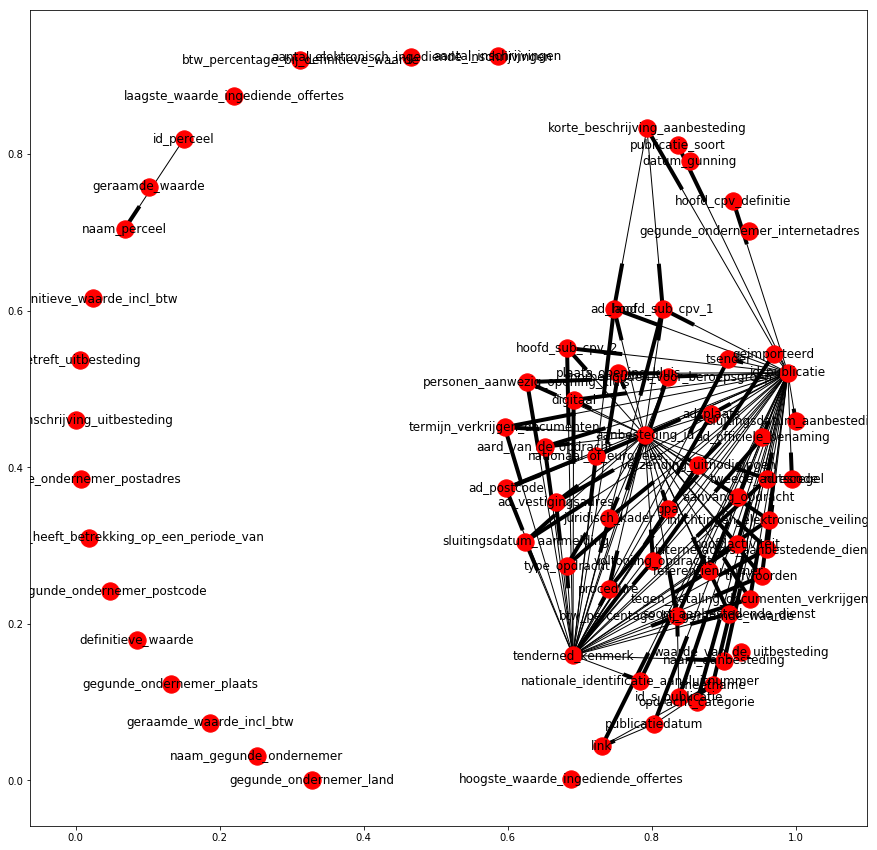

In [98]:
plt.figure(figsize = (15, 15))

nx.draw_networkx(uniqueness_graph)

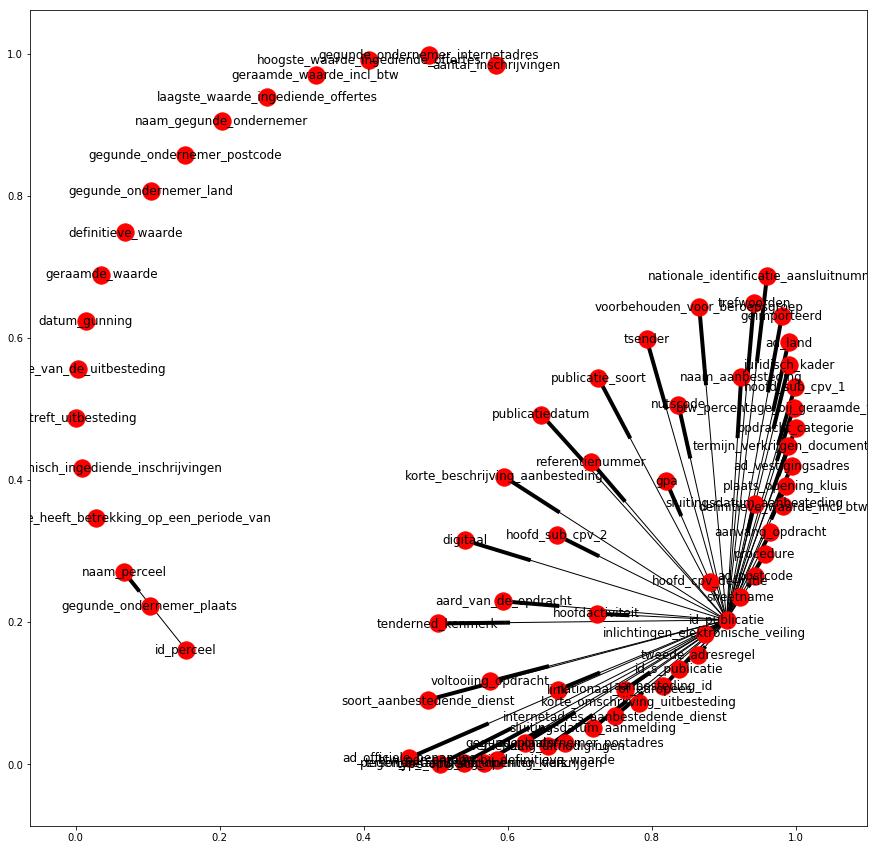

In [99]:
plt.figure(figsize = (15, 15))

nx.draw_networkx(nx.algorithms.tree.branchings.Edmonds(uniqueness_graph).find_optimum())

In [70]:
guide[guide.short == "tsender"]

,param,description,link,short
17,Tsender,"De naam van het aanbestedingssysteem (de Tsender), waaruit de aankondiging is geïmporteerd. Er zijn twaalf (12) Tsenders",https://www.tenderned.nl/cms/sites/default/files/2017-09/Dataset_TenderNed_2010_2011.xlsx,tsender


In [92]:
tenders.laagste_waarde_ingediende_offertes.groupby(tenders.tsender).size()

tsender
Aanbestedingskalender.nl       2871
BanenpleinLimburg.nl            253
CTM Solution BV                3411
Commerce-hub                    430
Flevolandhuurtin.nl             182
Groningenhuurtin.nl              50
IGOM.nl                          43
Lansingerlandhuurtin.nl          46
Negometrix                     3918
Talentenregiohuurtin.nl         357
VRKhuurtin.nl                     4
WerkenInNoordoostBrabant.nl      84
WerkenInZuidoostBrabant.nl        7
Werkenbijs-hertogenbosch.nl      48
Name: laagste_waarde_ingediende_offertes, dtype: int64